In [1]:
# try numpyro for MCMC

# plotting + data handling
import matplotlib.pyplot as plt
import pandas as pd
import corner

# numpy 
import numpy as np

# jax for automatic differentiation
import jax
import jax.numpy as jnp
key = jax.random.key(1234)

# numpyro for HMC
import numpyro

In [2]:
# Data

# import data from file
file = "code\1-Fragment_C_Hole_Measurements.csv"

# read csv 
df = pd.read_csv(file)

# just extract ID, X,Y values
data_col = df[["Section ID", "Mean(X)", "Mean(Y)"]]

jax_array = jnp.array(data_col)

# First index for ID, second index for X (1) or Y (2)
X = jax_array[:,1]
Y = jax_array[:,2]

data = [X,Y]


In [3]:
key, subkey = jax.random.split(key)

# model - takes parameters as input & calculates (xi, yi) positions on circle

# R radius of mechanism
# N npoints for whole mechanism
# sigma_r radial error
# sigma_t tangential error - for isotropic model set sigma_r = sigma_t = sigma (uniform x,y error)
# xc central position of x coordinate for each section (x8)
# yc central position of y coordinate for each section (x8)
# a alpha phase shift of each section (x8)

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...

def modelxy(N,R,a0,a1,a2,a3,a4,a5,a6,a7,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi,phi


In [4]:
# Aligned Model (radial-tangential)

def numpyro_model_aligned(X,Y):

    # priors on all parameters

    R = numpyro.sample("R", numpyro.distributions.Uniform(60, 100))
    N = numpyro.sample("N", numpyro.distributions.Uniform(340,370))

    xc0 = numpyro.sample("xc0", numpyro.distributions.Uniform(70,90))
    xc1 = numpyro.sample("xc1", numpyro.distributions.Uniform(70,90))
    xc2 = numpyro.sample("xc2", numpyro.distributions.Uniform(70,90))
    xc3 = numpyro.sample("xc3", numpyro.distributions.Uniform(70,90))
    xc4 = numpyro.sample("xc4", numpyro.distributions.Uniform(70,90))
    xc5 = numpyro.sample("xc5", numpyro.distributions.Uniform(70,90))
    xc6 = numpyro.sample("xc6", numpyro.distributions.Uniform(70,90))
    xc7 = numpyro.sample("xc7", numpyro.distributions.Uniform(70,90))

    yc0 = numpyro.sample("yc0", numpyro.distributions.Uniform(130,140))
    yc1 = numpyro.sample("yc1", numpyro.distributions.Uniform(130,140))
    yc2 = numpyro.sample("yc2", numpyro.distributions.Uniform(130,140))
    yc3 = numpyro.sample("yc3", numpyro.distributions.Uniform(130,140))
    yc4 = numpyro.sample("yc4", numpyro.distributions.Uniform(130,140))
    yc5 = numpyro.sample("yc5", numpyro.distributions.Uniform(130,140))
    yc6 = numpyro.sample("yc6", numpyro.distributions.Uniform(130,140))
    yc7 = numpyro.sample("yc7", numpyro.distributions.Uniform(130,140))

    a0 = numpyro.sample("a0", numpyro.distributions.Uniform(-150,-140))
    a1 = numpyro.sample("a1", numpyro.distributions.Uniform(-150,-140))
    a2 = numpyro.sample("a2", numpyro.distributions.Uniform(-150,-140))
    a3 = numpyro.sample("a3", numpyro.distributions.Uniform(-150,-140))
    a4 = numpyro.sample("a4", numpyro.distributions.Uniform(-150,-140))
    a5 = numpyro.sample("a5", numpyro.distributions.Uniform(-150,-140))
    a6 = numpyro.sample("a6", numpyro.distributions.Uniform(-150,-140))
    a7 = numpyro.sample("a7", numpyro.distributions.Uniform(-150,-140))

    # bundle all parameters:

    params = N,R,a0,a1,a2,a3,a4,a5,a6,a7,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7

    # model predictions for (X,Y)

    #model = numpyro.deterministic("model", modelrt(*params))

    #Xi, Yi, phi = model

    Xi, Yi, phi = modelxy(*params)

    # Project model Xi, Yi into radial & tangential components

    r_pi = Xi * jnp.cos(phi) + Yi * jnp.sin(phi)
    t_pi = Xi * jnp.sin(phi) - Yi * jnp.cos(phi)

    r_p = X * jnp.cos(phi) + Y * jnp.sin(phi)
    t_p = X * jnp.sin(phi) - Y * jnp.cos(phi)

    # priors for radial AND tangential sigmas

    sigma_r = numpyro.sample("sigma_r", numpyro.distributions.Normal(0.25, 0.5))
    sigma_t = numpyro.sample("sigma_t", numpyro.distributions.Normal(0.25, 0.5))

    with numpyro.plate("data", X.shape[0]):

        numpyro.sample("obs_r", numpyro.distributions.Normal(r_pi, sigma_r), obs=r_p)
        numpyro.sample("obs_t", numpyro.distributions.Normal(t_pi, sigma_t), obs=t_p)



In [5]:
# Run MCMC on radial/tangential model

nuts_kernel = numpyro.infer.NUTS(numpyro_model_aligned)
mcmc_aligned = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)

mcmc_aligned.run(subkey, X,Y)
mcmc_aligned.print_summary()  

/tmp/ipykernel_3855506/1474417771.py:4: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_aligned = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
sample: 100%|██████████| 1100/1100 [00:18<00:00, 58.65it/s, 1023 steps of size 4.00e-03. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.17      1.40    355.18    352.87    357.40   1941.06      1.00
         R     77.32      0.28     77.32     76.87     77.80   1937.76      1.00
        a0   -145.93      2.21   -145.87   -149.35   -142.41    128.48      1.08
        a1   -145.72      0.06   -145.72   -145.83   -145.62   2928.85      1.00
        a2   -145.68      0.19   -145.68   -145.99   -145.37   4053.12      1.00
        a3   -145.55      0.20   -145.55   -145.88   -145.22   1959.74      1.00
        a4   -144.94      2.92   -144.88   -149.66   -140.69    110.59      1.07
        a5   -146.71      0.90   -146.71   -148.17   -145.22   2483.69      1.01
        a6   -146.25      1.86   -146.30   -149.47   -143.31    252.68      1.03
        a7   -147.82      0.43   -147.82   -148.56   -147.16   2311.33      1.00
   sigma_r      0.03      0.00      0.03      0.02      0.03   5246.91      1.00
   sigma_t      0.13      0

In [6]:
# model - takes parameters as input & calculates (xi, yi) positions on circle

# R radius of mechanism
# N npoints for whole mechanism
# sigma_r radial error
# sigma_t tangential error - for isotropic model set sigma_r = sigma_t = sigma (uniform x,y error)
# xc central position of x coordinate for each section (x8)
# yc central position of y coordinate for each section (x8)
# a alpha phase shift of each section (x8)

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...

def modelxy(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi


In [7]:

# Isotropic Model

def numpyro_model_isotropic(X, Y):

    # priors on all parameters

    R = numpyro.sample("R", numpyro.distributions.Uniform(60, 100))
    N = numpyro.sample("N", numpyro.distributions.Uniform(340,370))

    xc0 = numpyro.sample("xc0", numpyro.distributions.Uniform(70,90))
    xc1 = numpyro.sample("xc1", numpyro.distributions.Uniform(70,90))
    xc2 = numpyro.sample("xc2", numpyro.distributions.Uniform(70,90))
    xc3 = numpyro.sample("xc3", numpyro.distributions.Uniform(70,90))
    xc4 = numpyro.sample("xc4", numpyro.distributions.Uniform(70,90))
    xc5 = numpyro.sample("xc5", numpyro.distributions.Uniform(70,90))
    xc6 = numpyro.sample("xc6", numpyro.distributions.Uniform(70,90))
    xc7 = numpyro.sample("xc7", numpyro.distributions.Uniform(70,90))

    yc0 = numpyro.sample("yc0", numpyro.distributions.Uniform(130,140))
    yc1 = numpyro.sample("yc1", numpyro.distributions.Uniform(130,140))
    yc2 = numpyro.sample("yc2", numpyro.distributions.Uniform(130,140))
    yc3 = numpyro.sample("yc3", numpyro.distributions.Uniform(130,140))
    yc4 = numpyro.sample("yc4", numpyro.distributions.Uniform(130,140))
    yc5 = numpyro.sample("yc5", numpyro.distributions.Uniform(130,140))
    yc6 = numpyro.sample("yc6", numpyro.distributions.Uniform(130,140))
    yc7 = numpyro.sample("yc7", numpyro.distributions.Uniform(130,140))

    a0 = numpyro.sample("a0", numpyro.distributions.Uniform(-150,-140))
    a1 = numpyro.sample("a1", numpyro.distributions.Uniform(-150,-140))
    a2 = numpyro.sample("a2", numpyro.distributions.Uniform(-150,-140))
    a3 = numpyro.sample("a3", numpyro.distributions.Uniform(-150,-140))
    a4 = numpyro.sample("a4", numpyro.distributions.Uniform(-150,-140))
    a5 = numpyro.sample("a5", numpyro.distributions.Uniform(-150,-140))
    a6 = numpyro.sample("a6", numpyro.distributions.Uniform(-150,-140))
    a7 = numpyro.sample("a7", numpyro.distributions.Uniform(-150,-140))

    # bundle all parameters:

    params = R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7



    # sigma_x = sigma_y so just use one sigma acting on both

    sigma = numpyro.sample("sigma", numpyro.distributions.Normal(0, 0.5))

    with numpyro.plate("data", X.shape[0]):

        # model predictions for (X,Y)
        Xi, Yi = modelxy(*params)


        numpyro.sample("obs_X", numpyro.distributions.Normal(Xi, sigma), obs=X)
        numpyro.sample("obs_Y", numpyro.distributions.Normal(Yi, sigma), obs=Y)




In [8]:
# Run MCMC on isotropic model

nuts_kernel = numpyro.infer.NUTS(numpyro_model_isotropic)
mcmc_isotropic = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
#key, subkey = jax.random.split(key)
mcmc_isotropic.run(subkey, X,Y)
mcmc_isotropic.print_summary()

/tmp/ipykernel_3855506/3337945293.py:4: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_isotropic = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
sample: 100%|██████████| 1100/1100 [00:17<00:00, 63.39it/s, 1023 steps of size 4.48e-03. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.65      3.73    355.59    349.45    361.61   1764.06      1.00
         R     77.43      0.81     77.42     76.07     78.71   1751.58      1.00
        a0   -146.02      2.25   -145.97   -149.98   -143.00   1214.99      1.01
        a1   -145.69      0.18   -145.69   -145.97   -145.39   3141.93      1.00
        a2   -145.64      0.59   -145.63   -146.60   -144.68   4501.40      1.00
        a3   -145.49      0.53   -145.49   -146.43   -144.67   1788.85      1.00
        a4   -145.01      2.91   -145.03   -150.00   -140.99   2231.63      1.00
        a5   -146.07      2.28   -146.24   -149.99   -142.87   4346.52      1.00
        a6   -145.16      2.72   -145.22   -149.98   -141.36   2260.36      1.00
        a7   -147.64      1.17   -147.69   -149.66   -145.87   3010.53      1.00
     sigma      0.09      0.01      0.09      0.09      0.10   5196.16      1.00
       xc0     79.76      1

In [9]:
# get posterior samples 

posterior_aligned = mcmc_aligned.get_samples()['N']
posterior_isotropic = mcmc_isotropic.get_samples()['N']

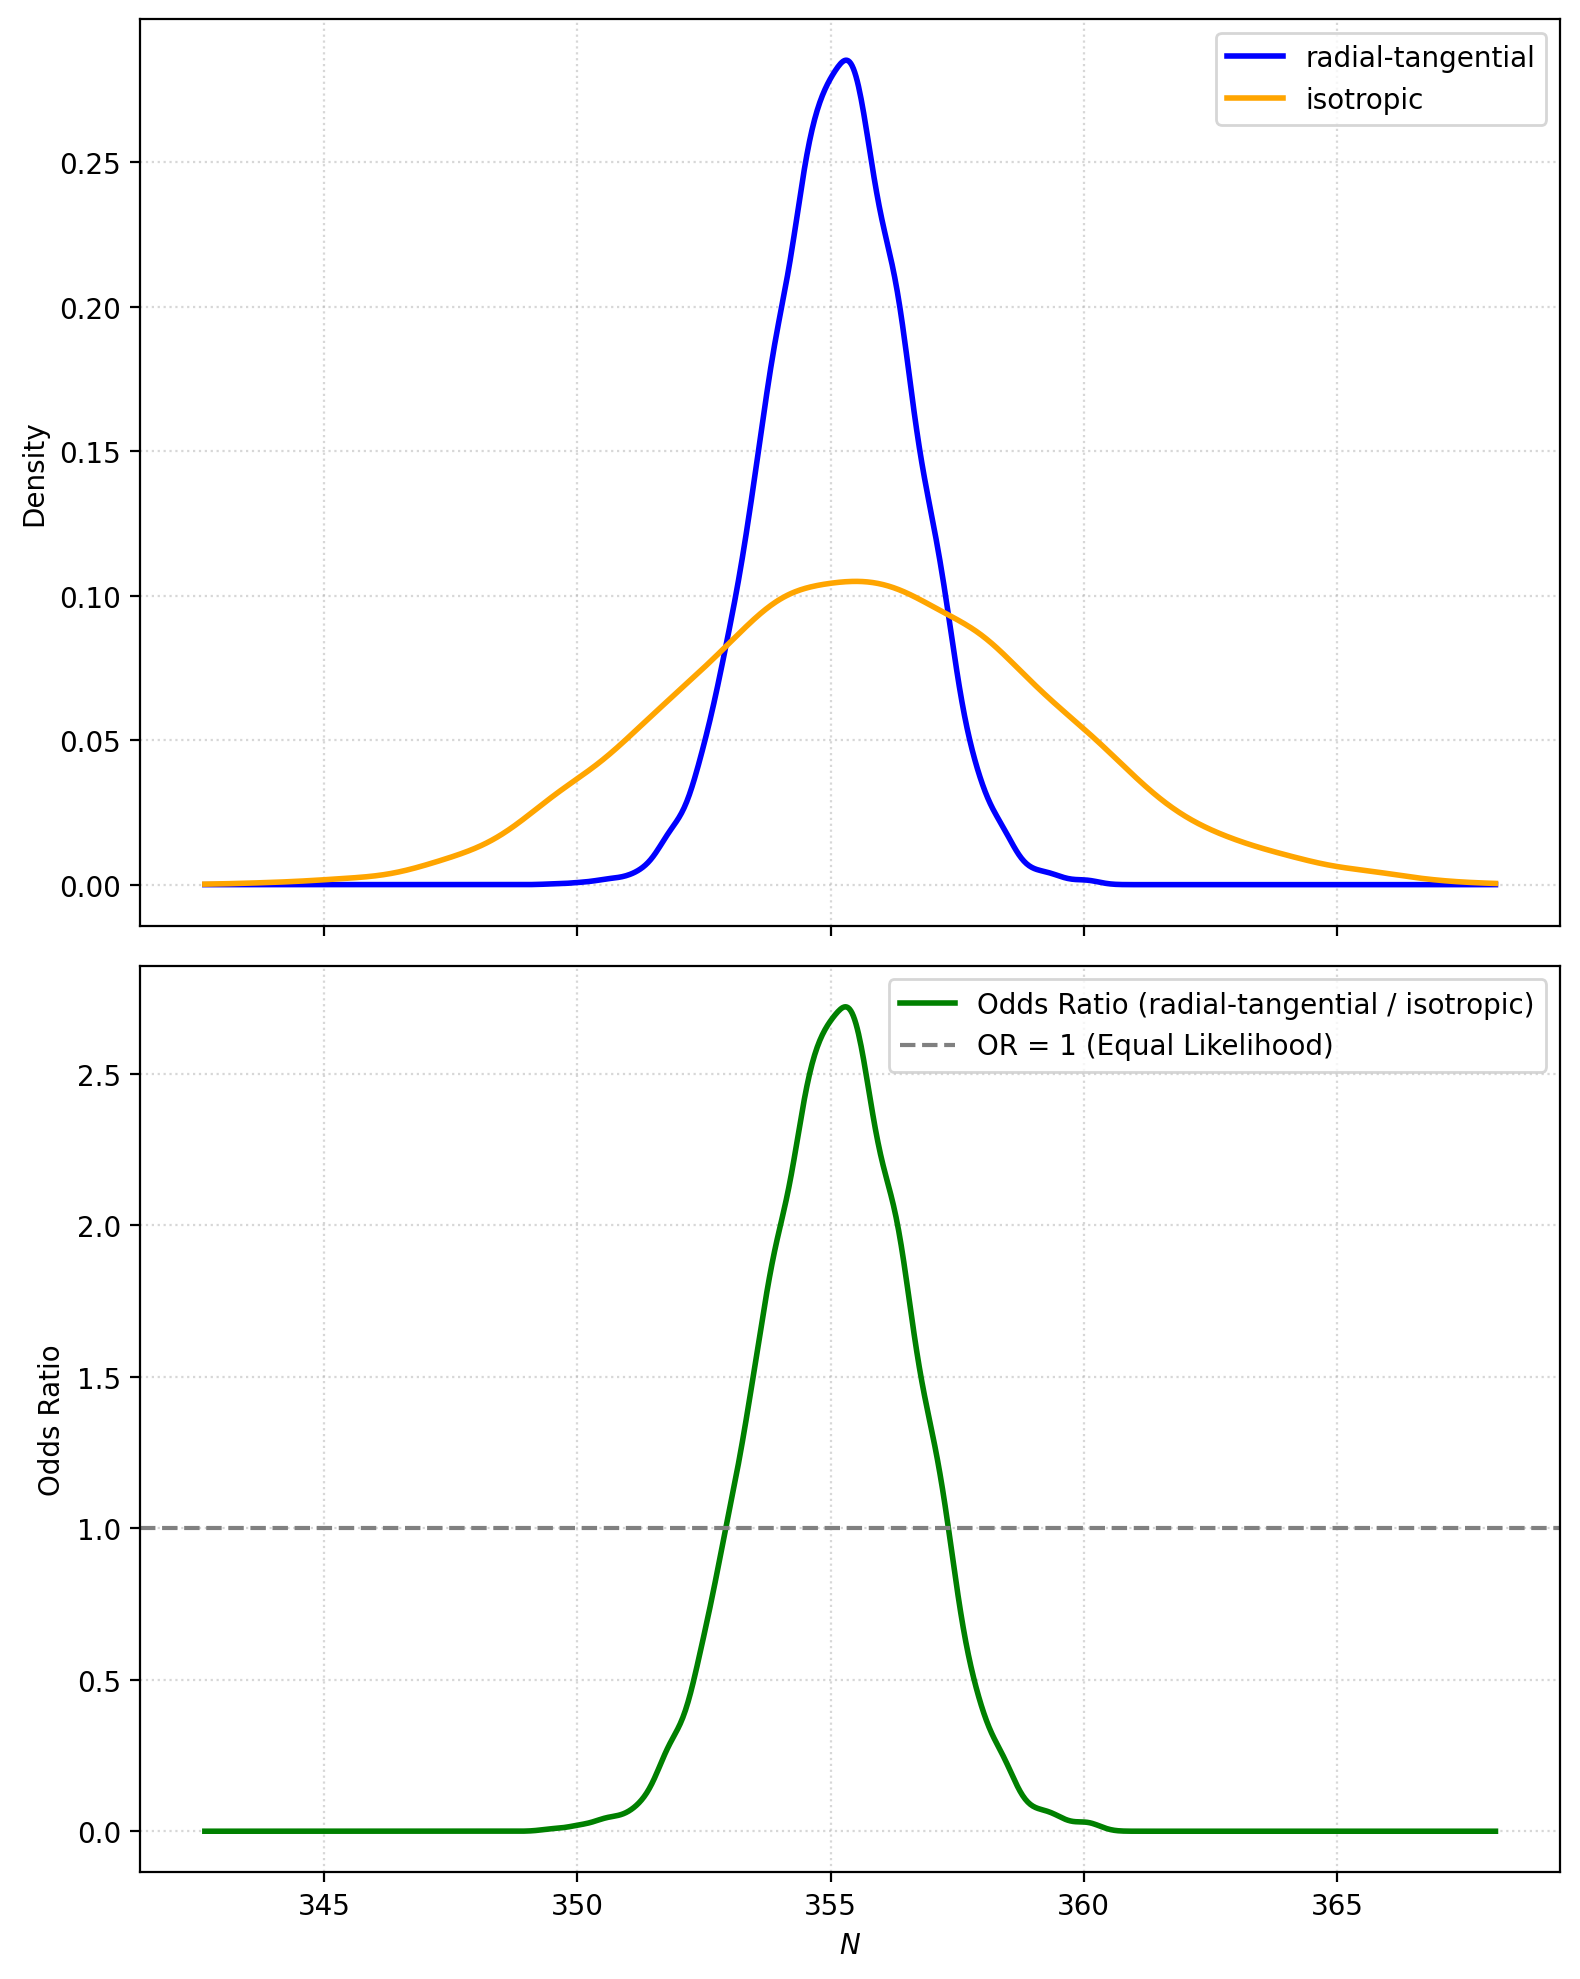

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Kernel Density Estimation (KDE) to smooth the posterior distributions
kde_rt = gaussian_kde(posterior_aligned)
kde_iso = gaussian_kde(posterior_isotropic)

# Define the range for the posterior distributions
x = np.linspace(min(posterior_aligned.min(), posterior_isotropic.min()), 
                 max(posterior_aligned.max(), posterior_isotropic.max()), 1000)

# Compute the densities
pdf_rt = kde_rt(x)
pdf_iso = kde_iso(x)

# Calculate the odds ratio
odds_ratio = pdf_rt / pdf_iso

# Plot the posterior distributions and the odds ratio
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

fig.set_dpi(200)

# Plot posterior distributions
ax[0].plot(x, pdf_rt, label='radial-tangential', color='blue', linewidth=2)
ax[0].plot(x, pdf_iso, label='isotropic', color='orange', linewidth=2)
ax[0].set_ylabel('Density')
ax[0].legend()
ax[0].grid(True, linestyle=":", alpha=0.5)

# Plot the odds ratio
ax[1].plot(x, odds_ratio, color='green', linewidth=2, label='Odds Ratio (radial-tangential / isotropic)')
ax[1].set_xlabel(r"$N$")
ax[1].set_ylabel('Odds Ratio')
ax[1].axhline(1, color='gray', linestyle='--', label='OR = 1 (Equal Likelihood)')
ax[1].legend()
ax[1].grid(True, linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()
